# PPO training & test notebook

In [1]:
from PPO_train_test import PPOTrainer
import numpy as np
import pandas as pd
from datetime import datetime

## Example of using the class

In [23]:
trainer = PPOTrainer(train_domain = "source",
        test_domain = "target",
        use_udr = False,                                # use UDR Uniform Domain Randomization
        seed = 42,
        total_timesteps = 200000,                       # training timesteps
        model_path = "models/ppo_hopper",               # path to save the model
        learning_rate=3e-4, 
        n_steps=4096,                                   # number of steps to run for each environment per update
        batch_size=64,                                 # minibatch size
        n_epochs=15,                                    # number of epochs to update the policy
        verbose=0,                                      # verbosity level: 0 for no output, 1 for training info
        n_eval_episodes=50)                             # number of episodes to evaluate the policy


# train + test the model 
(mean, std), time = trainer.run()

# only train 
# trainer.train()

# only test
# trainer.evaluate()

 Training completed and model saved.

Mean reward on CustomHopper-target-v0: 1018.50 ± 34.79


## GRID SEARCH: training and test on varoius seeds and hyperparameters 

In [2]:
seeds = [42, 35, 254, 78, 91]
l_rates = [1e-3, 3e-4]
n_steps = [2048, 4096]
batch_sz = [64, 256]
n_epochs = [10, 15]

Note: to train and evaluate across various “source” and “target” environments—and to incorporate the domain randomization described in the paper—we use the following code cell, supplying different parameter sets to the PPOTrainer.

In [ ]:
means = []
stds = []
times = []
for lr in l_rates:
    mean_ns = []
    std_ns = []
    time_ns = []
    for ns in n_steps:
        mean_bs = []
        std_bs = []
        time_bs = []
        for bs in batch_sz:
            mean_ne = []
            std_ne = []
            time_ne = []
            for ne in n_epochs:
                mean_s=0
                std_s=0
                time_s=0
                for i,s in enumerate(seeds):
                    model_name = f'PPO_lr{lr}_ns{ns}_bs{bs}_ne{ne}_s{s}_noUDR_'+datetime.now().strftime('%y%m%d_%H-%M-%S')
                    trainer = PPOTrainer(train_domain = "source",
                        test_domain = "source",
                        use_udr = False,             
                        seed = s,
                        total_timesteps = 200000,  
                        model_path = "models/"+model_name,  
                        learning_rate=lr, 
                        n_steps=ns,               
                        batch_size=bs,             
                        n_epochs=ne,                
                        verbose=0,                
                        tensorboard_log='models/'+model_name+'_tensorboard',
                        n_eval_episodes=50)         
                    (mean, std), train_time = trainer.run()
                    mean_s = mean_s*(i/(i+1))+mean/(i+1)
                    std_s = std_s*(i/(i+1))+std/(i+1)
                    time_s = time_s*(i/(i+1))+train_time/(i+1)
                mean_ne.append(mean_s)
                std_ne.append(std_s)
                time_ne.append(time_s)
            mean_bs.append(mean_ne)
            std_bs.append(std_ne)
            time_bs.append(time_ne)
        mean_ns.append(mean_bs)
        std_ns.append(std_bs)
        time_ns.append(time_bs)
    means.append(mean_ns)
    stds.append(std_ns)
    times.append(time_ns)

means_array_dr = np.array(means)
stds_array_dr = np.array(stds)
times_array_dr = np.array(times)

 Training completed and model saved.

Mean reward on CustomHopper-source-v0: 1589.91 ± 46.64
 Training completed and model saved.

Mean reward on CustomHopper-source-v0: 1441.45 ± 17.79
 Training completed and model saved.

Mean reward on CustomHopper-source-v0: 1581.42 ± 11.30
 Training completed and model saved.

Mean reward on CustomHopper-source-v0: 1571.35 ± 27.28
 Training completed and model saved.

Mean reward on CustomHopper-source-v0: 1191.03 ± 175.63
 Training completed and model saved.

Mean reward on CustomHopper-source-v0: 1603.38 ± 16.74
 Training completed and model saved.

Mean reward on CustomHopper-source-v0: 954.24 ± 137.42
 Training completed and model saved.

Mean reward on CustomHopper-source-v0: 1051.70 ± 42.03
 Training completed and model saved.

Mean reward on CustomHopper-source-v0: 1564.76 ± 11.71
 Training completed and model saved.

Mean reward on CustomHopper-source-v0: 1435.59 ± 4.14
 Training completed and model saved.

Mean reward on CustomHopper-sour

## Heatmaps of results

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

#creation of a viridis map
viridis = matplotlib.colormaps['viridis'].resampled(280)
newcolors = viridis(np.linspace(0, 1, 280))[:210]
newcmp=matplotlib.colors.ListedColormap(newcolors)

In [ ]:
def heatMapGridSearch(modelResults): 
    fig,axs=plt.subplots(1,1,figsize=(5,4))
    square=pd.DataFrame()   
    for lr in range(len(l_rates)):
        col=pd.DataFrame()
        for ns in range(len(n_steps)):
            df = pd.DataFrame(modelResults[lr,ns])
            col=pd.concat([col,df])
        square=pd.concat([square,col], axis=1)
        
    batch_sz = [64, 256, 64, 256]
    n_epochs = [10, 15, 10, 15]
    im=axs.imshow(square.astype(float),cmap=newcmp) 
    axs.set_yticks(range(len(square.index)))
    axs.set_yticklabels(batch_sz)
    axs.set_xticks(range(len(square.columns)))
    axs.set_xticklabels(n_epochs)
    
    axs.set_xlabel("num. epochs")
    axs.set_ylabel("batch size")
    for a in range(len(square.index)):
        for j in range(len(square.columns)):
            c="w"
            if square.iloc[a, j]==square.values.max():
                c="red"
            text = axs.text(j, a, "{0:.2f}".format(square.iloc[a, j]),
                        ha="center", va="center", color=c)
    
    axs.axhline(y=1.5,c="black",linewidth=0.75,zorder=0)
    axs.axvline(x=1.5,c="black",linewidth=0.75,zorder=0)
    
    axs.text(4, 1.5, 'num. steps', ha="center", va="center", rotation='vertical')
    axs.text(1.5, -1, 'learning rate', ha="center", va="center")
    axs.text(0.5, -0.7, '1e-3', ha="center", va="center")
    axs.text(2.5, -0.7, '3e-4', ha="center", va="center")
    axs.text(3.75, 0.5, '2048', ha="left", va="center")
    axs.text(3.75, 2.5, '4096', ha="left", va="center")

    cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    #plt.savefig('PPO_times_source',dpi=300)
    plt.show()
    

## Show results: 
-mean of test reward 

-standard deviation of test reward


-training times 

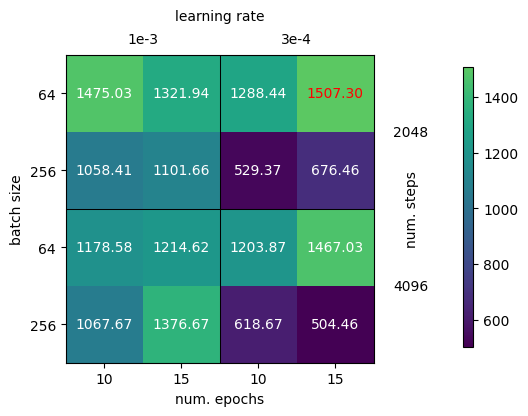

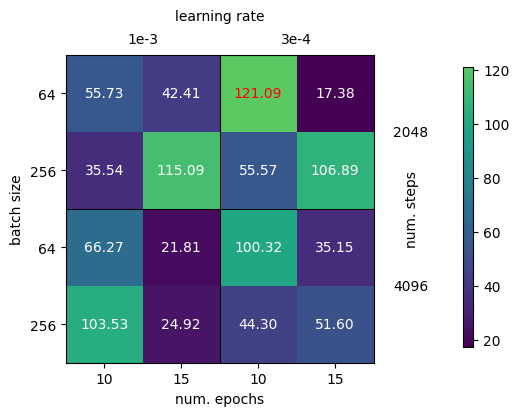

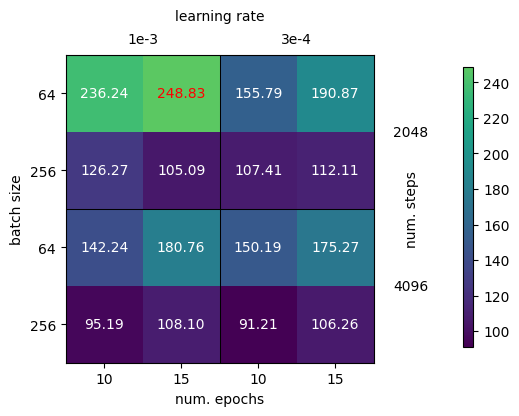

In [7]:
heatMapGridSearch(means_array_dr)
heatMapGridSearch(stds_array_dr)
heatMapGridSearch(times_array_dr)